### 1.- Load the Random Forest model

The model is stored in Open Neural Network Exchange (ONNX) format. This supports long term maintenance: ONNX is an open standard for storing machine learning models, whereas pickled objects are permanently fixed to a single (sklearn) library version, deprived of potential future bugfixes or improvements. The ONNX implementation is also  reputed to outperform scikit-learn, in this example improving from 9.5 seconds to 6.9 seconds, as well as reducing storage (from 137M to 88M). Pickle and ONNX are the main two options for model persistance advised by scikit-learn.

In [1]:
# Perform format conversion (unpickling assumes matching sklearn version)

#import skl2onnx
#import pickle5 as pickle
#with open('rf_fmc.pickle', 'rb') as handle:
#    rf = pickle.load(handle)
#rf2 = skl2onnx.convert_sklearn(rf, 
#          initial_types=[('float_input', skl2onnx.common.data_types.FloatTensorType([None, 9]))], 
#          final_types=[('fmc', None)])
#with open("randomforest.onnx", 'wb') as f:
#    f.write(rf2.SerializeToString())

In [2]:
#!pip install onnxruntime
import onnxruntime
model = onnxruntime.InferenceSession("../randomforest.onnx")

### 2.- Load DEA data for Namadgi region

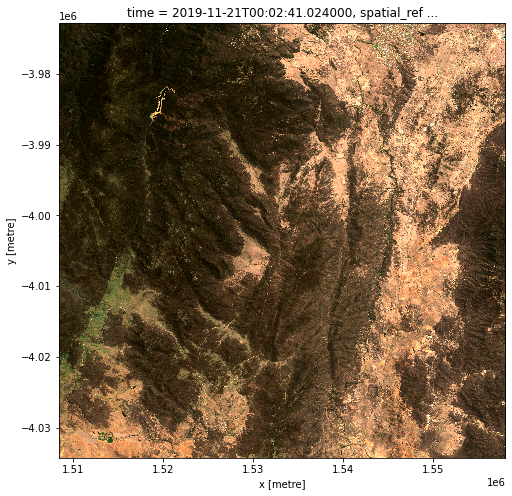

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import datacube
import xarray as xr

dc = datacube.Datacube(app='fmc')

query = {
        'y': (-3972822.7900266224, -4034237.9891385734),
        'x': (1508424.0286794726, 1558083.9107398288),
        'crs': 'EPSG:3577',
        'output_crs': 'EPSG:3577',
        'resolution': (-25, 25),
        'time': ('2019-11-20', '2019-11-22'),
        'measurements': ["nbar_blue","nbar_green","nbar_red",
                         "nbart_red_edge_1","nbart_red_edge_2","nbart_red_edge_3",
                         "nbar_nir_1","nbar_nir_2",
                         "nbar_swir_2","nbar_swir_3"],}

ds = dc.load(product='s2a_ard_granule', group_by='solar_day', **query)

ds = ds.isel(time=0)

ds[['nbar_red', 'nbar_green', 'nbar_blue']].to_array().plot.imshow(robust=True, figsize=(8,8))

### 3.- Add NDVI and NDII normalised indices to the dataset

In [4]:
ds['ndvi']=((ds.nbar_nir_1-ds.nbar_red)/(ds.nbar_nir_1+ds.nbar_red))
ds['ndii']=((ds.nbar_nir_1-ds.nbar_swir_2)/(ds.nbar_nir_1+ds.nbar_swir_2))

### 4.- Stack and reshape dataset to be compatible with the RF input

In [5]:
refl = ds[['ndvi','ndii','nbar_red','nbar_green','nbar_blue','nbar_nir_1','nbar_nir_2','nbar_swir_2','nbar_swir_3']].to_array().values
refl_rf = refl.reshape((9,-1)).swapaxes(0,1)

### 5.- Estimate FMC values using RF model and previous reflectance input

In [6]:
# Note, input data is converted from float64 to float32. However, most values are integers.

rf_fmc = model.run(['fmc'], {'float_input': refl_rf.astype('f4')})[0] 

fmc = rf_fmc.reshape(refl.shape[1:])

### 6.- Create colormap consistent with the current Australian Fuel Monitoring System

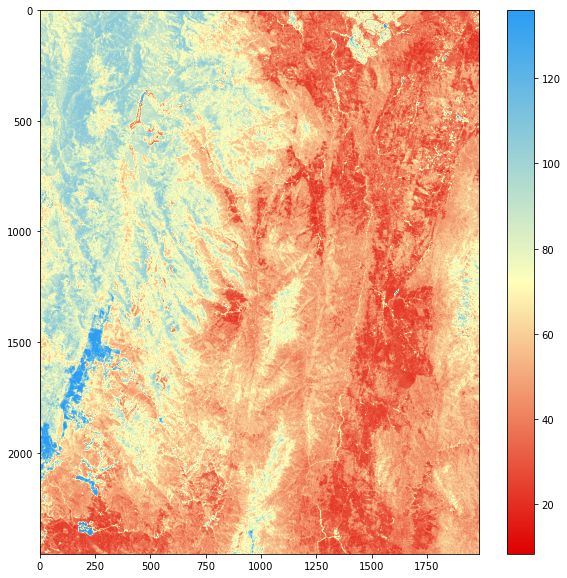

In [7]:
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

colors = [(0.87, 0, 0), (1, 1, 0.73), (0.165, 0.615, 0.957)]  # R -> G -> B
cmap = LinearSegmentedColormap.from_list('fmc', colors, N=256)
plt.figure(figsize=(10,10))
plt.imshow(np.clip(fmc, 0, 136), cmap=cmap)
plt.colorbar()